In [1]:

import os
import sys
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from itertools import product
from sklearn.preprocessing import RobustScaler, LabelEncoder

sys.path.extend([
                '../src',
                '../data',
                ])

from utils import run_nested_cv_3b

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("CPU")
    
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

#data
left = pd.read_csv('../data/left.csv')
right = pd.read_csv('../data/right.csv')
affected = pd.read_csv('../data/affected.csv')
unaffected = pd.read_csv('../data/unaffected.csv')

#limb
right['limb'] = 1
left['limb'] = 2
affected['limb'] = 3
unaffected['limb'] = 4

affected['subject'] = affected['subject'] + 10
unaffected['subject'] = unaffected['subject'] + 10

le = LabelEncoder()
right['use_type_encoded'] = le.fit_transform(right['use_type'])
left['use_type_encoded'] = le.fit_transform(left['use_type'])
affected['use_type_encoded'] = le.fit_transform(affected['use_type'])
unaffected['use_type_encoded'] = le.fit_transform(unaffected['use_type'])

combined = pd.concat([unaffected, 
                      affected, 
                      right, 
                      left], ignore_index=True)

architecture = {
                'num_filters': [50, 25],
                'filter_sizes': [5, 5],
                'pool_sizes': [5, 5]
               }

CPU


2025-07-10 12:35:24.736034: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x31819fd60>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x31819fbe0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x17b687940>, 'optimizer': 'nadam'} with score: 0.239


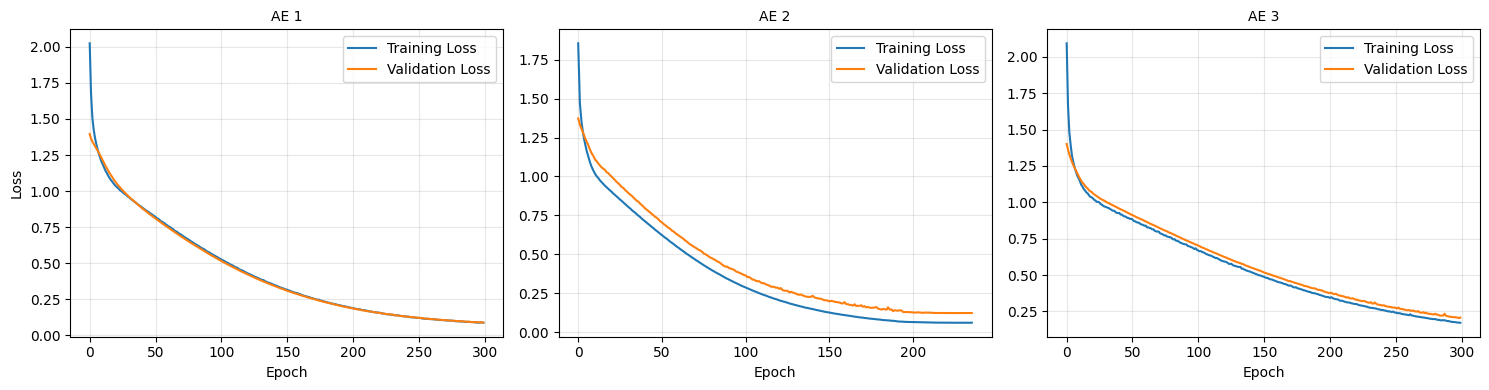

Limb: 2 Subject: 1 Youden Index: 0.23955904176383291 Sensitivity: 0.9811320754716981 Specificity: 0.25842696629213485
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x31819fd60>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x31819fbe0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x17b687940>, 'optimizer': 'nadam'} with score: 0.227


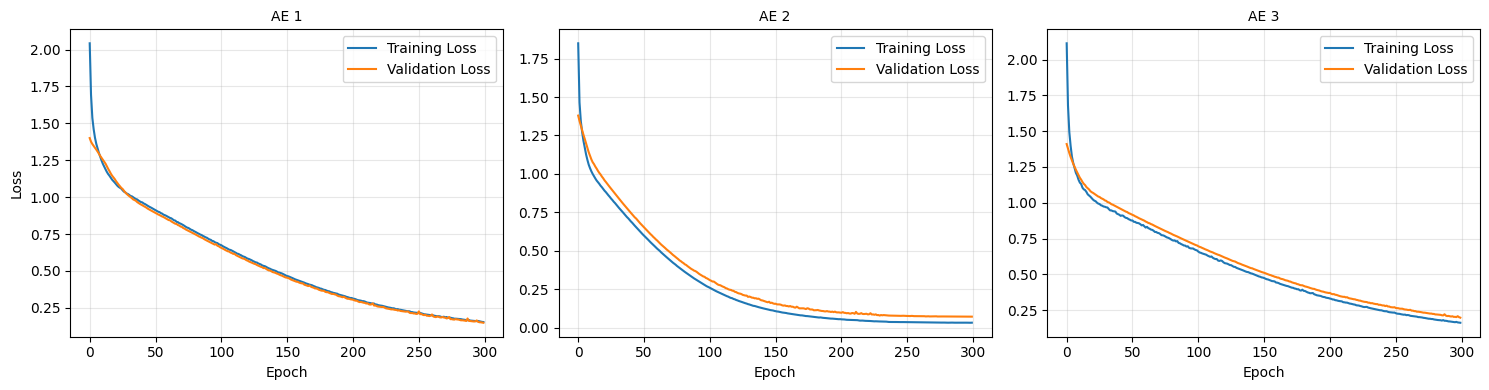

Limb: 2 Subject: 2 Youden Index: 0.16196162046908325 Sensitivity: 0.9828571428571429 Specificity: 0.1791044776119403
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x31819fd60>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x31819fbe0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x17b687940>, 'optimizer': 'nadam'} with score: 0.200
New best HP found: {'activation': 'tanh', 'batch_norm': False, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x31819fd60>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x31819fbe0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x17b687940>, 'optimizer': 'nadam'} with score: 0.206


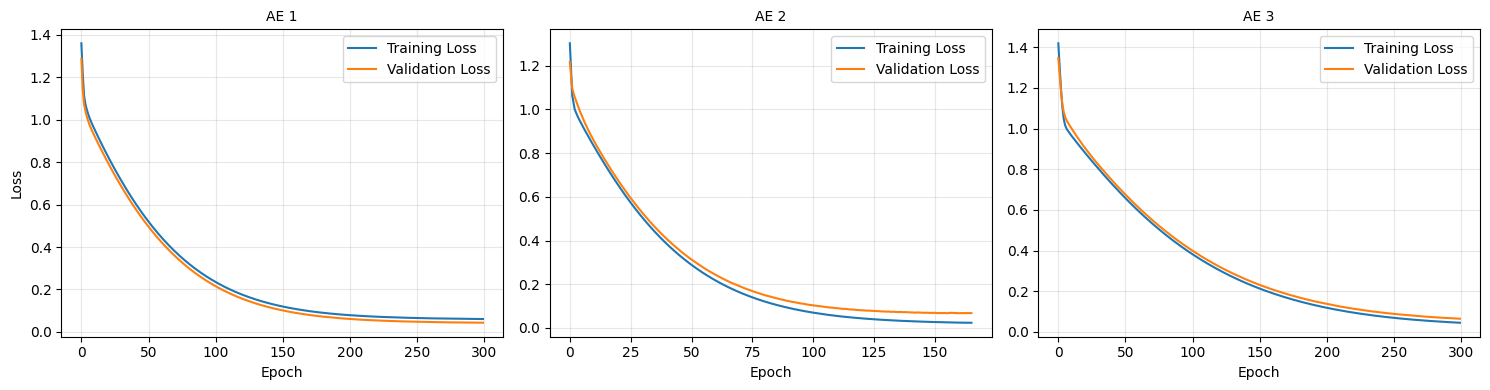

Limb: 2 Subject: 3 Youden Index: 0.08080808080808088 Sensitivity: 0.803030303030303 Specificity: 0.2777777777777778
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x31819fd60>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x31819fbe0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x17b687940>, 'optimizer': 'nadam'} with score: 0.238


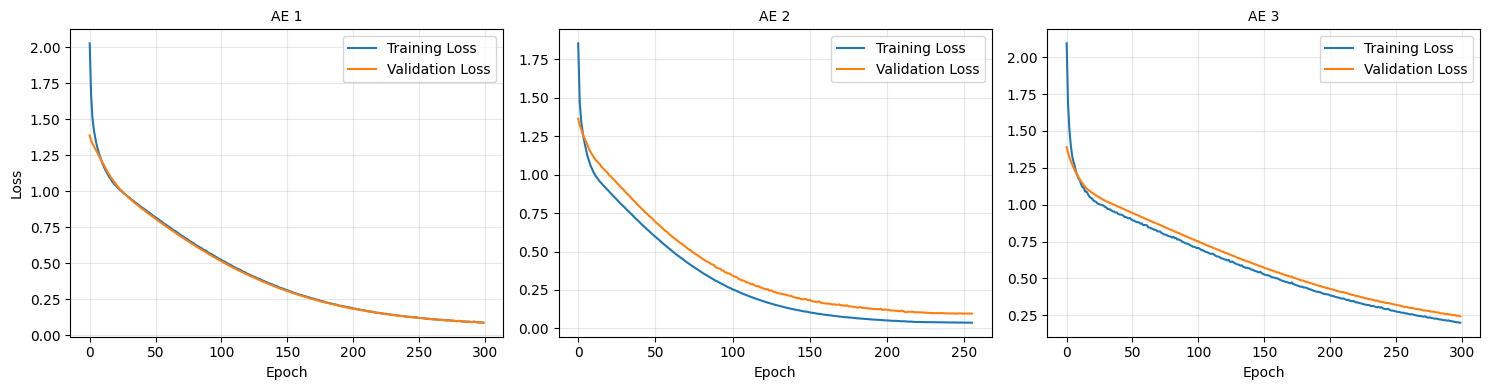

Limb: 2 Subject: 4 Youden Index: 0.2857142857142856 Sensitivity: 1.0 Specificity: 0.2857142857142857
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x31819fd60>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x31819fbe0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x17b687940>, 'optimizer': 'nadam'} with score: 0.230


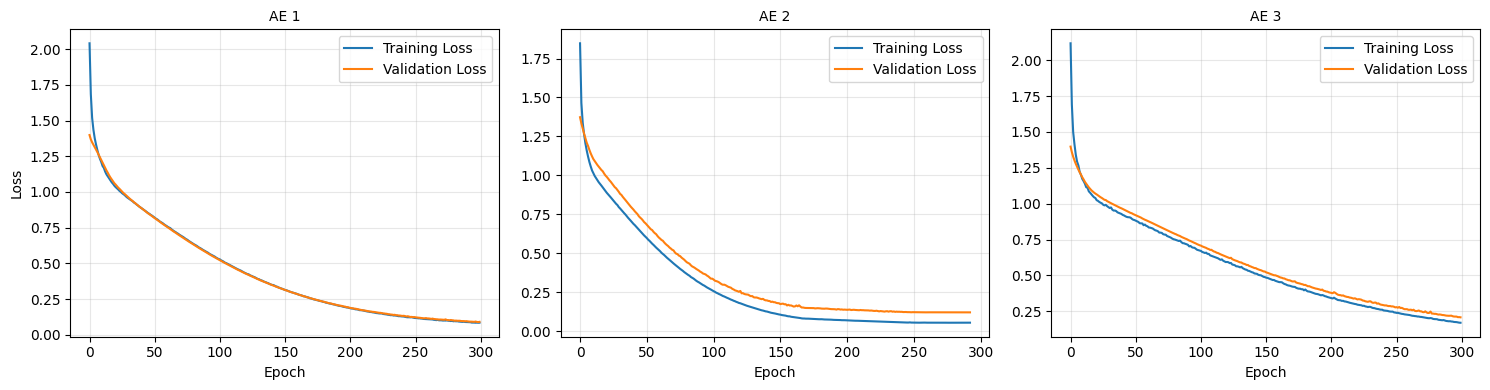

Limb: 2 Subject: 5 Youden Index: 0.29610655737704916 Sensitivity: 0.9836065573770492 Specificity: 0.3125
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x31819fd60>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x31819fbe0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x17b687940>, 'optimizer': 'nadam'} with score: 0.217
New best HP found: {'activation': 'tanh', 'batch_norm': False, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x31819fd60>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x31819fbe0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x17b687940>, 'optimizer': 'nadam'} with score: 0.225


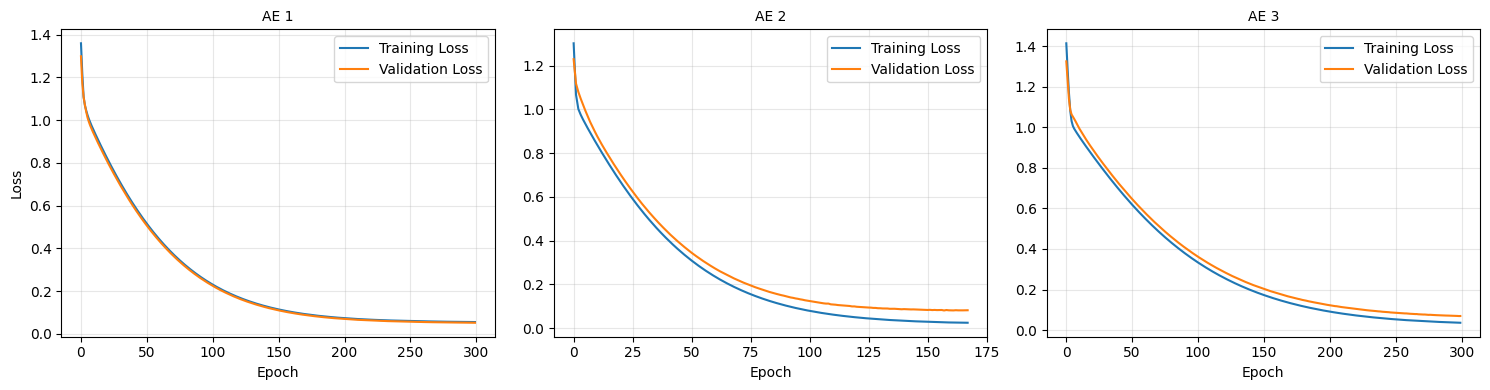

Limb: 2 Subject: 6 Youden Index: 0.22318079519879985 Sensitivity: 0.9651162790697675 Specificity: 0.25806451612903225
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x31819fd60>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x31819fbe0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x17b687940>, 'optimizer': 'nadam'} with score: 0.238


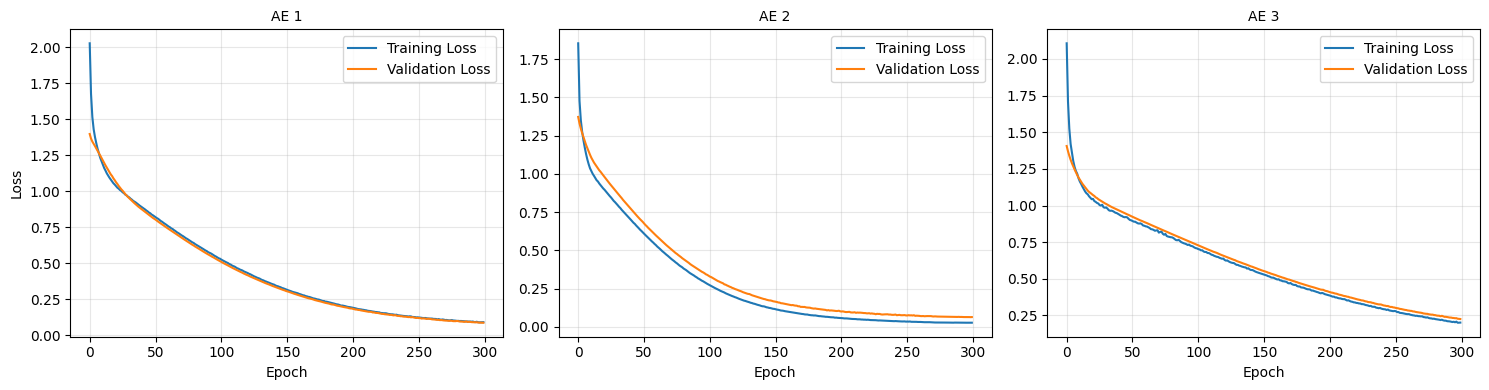

Limb: 2 Subject: 7 Youden Index: 0.18391330891330893 Sensitivity: 0.9861111111111112 Specificity: 0.1978021978021978
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x31819fd60>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x31819fbe0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x17b687940>, 'optimizer': 'nadam'} with score: 0.216


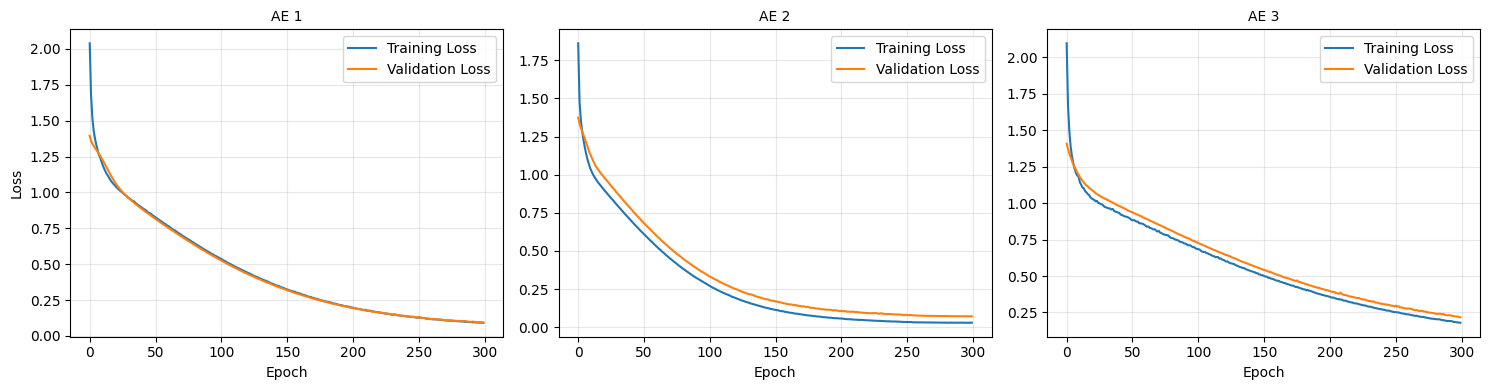

Limb: 2 Subject: 8 Youden Index: 0.23338566195709043 Sensitivity: 0.9897959183673469 Specificity: 0.24358974358974358
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x31819fd60>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x31819fbe0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x17b687940>, 'optimizer': 'nadam'} with score: 0.247


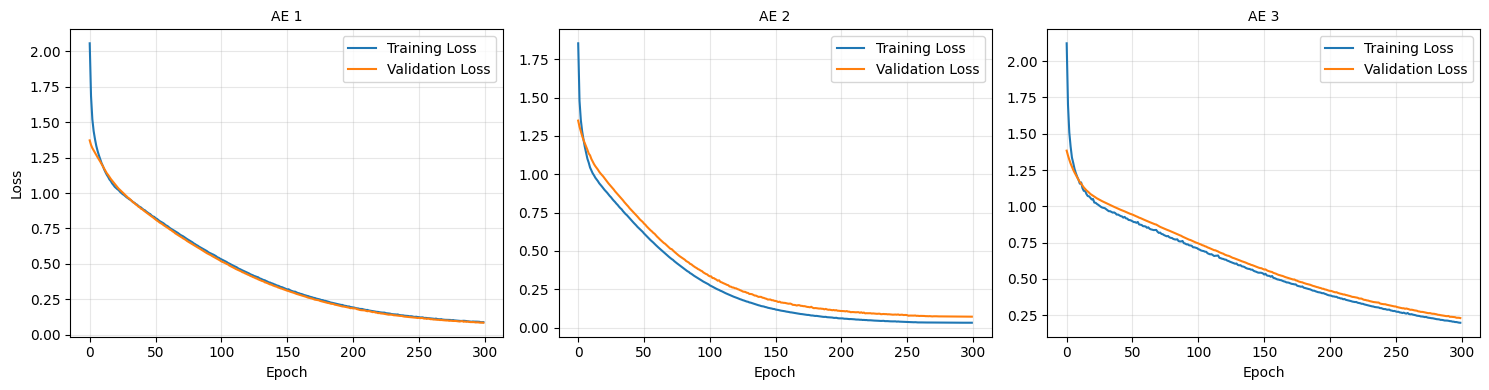

Limb: 2 Subject: 9 Youden Index: 0.12051056338028165 Sensitivity: 0.99375 Specificity: 0.1267605633802817
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x31819fd60>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x31819fbe0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x17b687940>, 'optimizer': 'nadam'} with score: 0.270


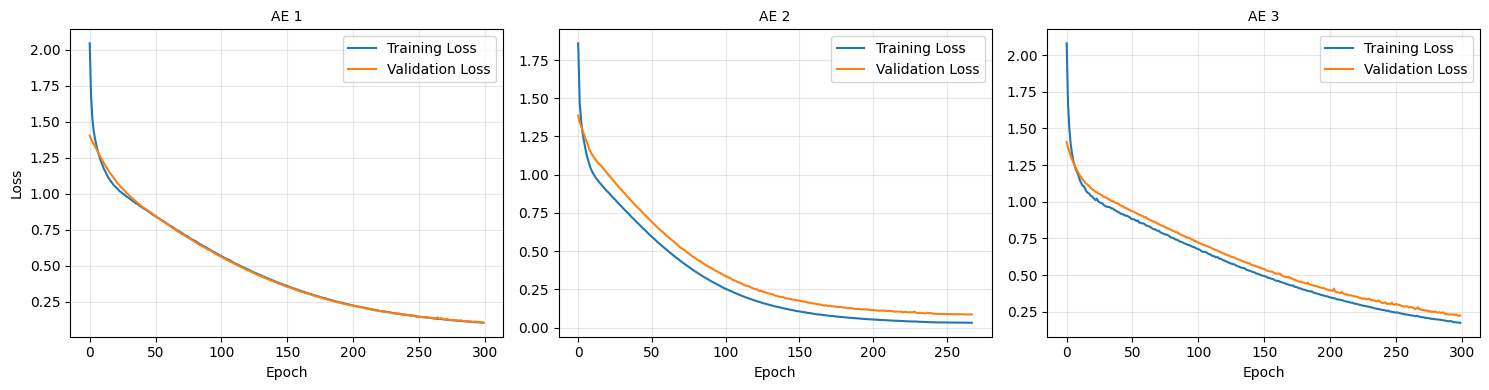

Limb: 2 Subject: 10 Youden Index: 0.24433077578857643 Sensitivity: 0.9855072463768116 Specificity: 0.25882352941176473
0.20694706913703892 0.06596503823262112


In [2]:


approach = 3
filename = f'../results/approach3b/limb_nested_cv_left.csv'

window_size = 100
epochs = 300
batch_size = 32

class_loss = False
plot_hist = True

error_func = 'mae'

X = left[['ax', 'ay', 'az']]
y = left['gnd']
subjects = left['subject']
limbs = left['limb']
usetypes = left['use_type_encoded']

hp = {
    'activation': ['tanh'],
    'kernel_init': [tf.keras.initializers.GlorotNormal(seed=42), ],           
    'bias_init': [tf.keras.initializers.Zeros()],
    'optimizer': ['nadam'],
    'loss': [tf.keras.losses.mean_squared_error, ],     
    'learning_rate': [0.0001],
    'batch_norm': [True, False]
    }

results_3b = run_nested_cv_3b(window_size,             
                              X=X,                         
                              y=y,                        
                              subjects=subjects,           
                              limbs=limbs,   
                              usetypes=usetypes,                  
                              architecture=architecture,   
                              hp_grid=hp,
                              epochs=epochs,                  
                              batch_size=batch_size,              
                              class_loss=False,           
                              plot_hist=True,            
                              error_func='None')

print(np.mean(results_3b['youden_index']), np.std(results_3b['youden_index']))